In [17]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout, Bidirectional, BatchNormalization, Conv2D, MaxPool2D, GRU
from matplotlib import pyplot
from keras.models import load_model
from tensorflow.keras.applications.resnet50 import ResNet50

In [18]:
data_f = open("features.pickle","rb")
data = pickle.load(data_f)
data_f.close()

In [19]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)

(8732,) (8732,)


In [20]:
X = np.empty([8732, 128])
for i in range(8732):
    X[i] = (X_[i])

In [21]:
Y = to_categorical(Y)

In [22]:
print(X.shape, Y.shape)

(8732, 128) (8732, 10)


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1, stratify=Y)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(6549, 128) (2183, 128) (6549, 10) (2183, 10)


In [24]:
X_train = X_train.reshape(6549, 16, 8)
X_test  = X_test.reshape(2183, 16, 8)

# X_train, X_test shape : (total # of training examples, sequence_length, input_dim)
# Y_train, Y_test shape : (total # of training examples, # output classes)

X_train_cnn = X_train.reshape(6549, 16, 8, 1)
X_test_cnn  = X_test.reshape(2183, 16, 8, 1)

In [25]:
from tensorflow.keras.layers import Input
input_tensor = Input(shape=(16, 8, 1))

In [ ]:
def get_lstm_model():
    model = Sequential()
    model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0, return_sequences=True, input_shape=(16, 8)))
    model.add(LSTM(units=32,  dropout=0.05, recurrent_dropout=0, return_sequences=False))
    model.add(Dense(units=10, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

In [ ]:
def get_bi_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=128, dropout=0.05, recurrent_dropout=0, return_sequences=True, input_shape=(16, 8))))
    model.add(Bidirectional(LSTM(units=32,  dropout=0.05, recurrent_dropout=0, return_sequences=False)))
    model.add((Dense(units=10, activation="softmax")))
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

In [ ]:
def get_cnn_model():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = (16, 8, 1)))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(1024, activation = "tanh"))
  model.add(Dense(10, activation = "softmax"))
  model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
  return model

In [30]:
def get_gru_model():
  model = Sequential()
  model.add(keras.layers.GRU(128, input_shape=(16, 8)))
  model.add(keras.layers.Dense(128, activation="relu"))
  model.add(keras.layers.Dense(10, activation = "softmax"))
  model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
  return model

In [ ]:
def get_resnet_model():
  pretrained_model = ResNet50(include_top=False, input_tensor=input_tensor, weights='imagenet')
  if pretrained_model.output.shape.ndims > 2:
        output = Flatten()(pretrained_model.output)
  else:
    output = pretrained_model.output
  output = BatchNormalization()(output)
  output = Dropout(0.5)(output)
  output = Dense(128, activation='relu')(output)
  output = BatchNormalization()(output)
  output = Dropout(0.5)(output)
  output = Dense(len(all_character_names), activation='softmax')(output)
  model = Model(pretrained_model.input, output)
  for layer in pretrained_model.layers:
      layer.trainable = False
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [34]:
def train_model(model, X_tr, Y_tr, X_te, Y_te):
    loss = list()
    accuracy = list()
    for _ in range(85):
        hist = model.fit(X_tr, Y_tr, epochs = 1, batch_size = 50, validation_data = (X_te, Y_te), verbose=0)
        loss.append(hist.history['loss'][0])
        accuracy.append(hist.history['accuracy'][0])
    return loss, accuracy

In [28]:
def evaluate_maodel(model, Xt, Yt):
  score, accuracy = model.evaluate(Xt, Yt, batch_size=50, verbose=1)
  print(f" Test loss     : {score*100}\n Test accuracy : {accuracy*100}")

In [ ]:
loss_results = pd.DataFrame()
acc_results = pd.DataFrame()

In [ ]:
model1 = get_lstm_model()
loss_results['lstm'], acc_results['lstm'] = train_model(model1, X_train, Y_train, X_test, Y_test)

In [35]:
#model1.save("model_lstm.h5")
model1 = keras.models.load_model('/content/model_lstm.h5')
evaluate_maodel(model1, X_test, Y_test)

44/44 [==============================] - 0s 3ms/step - loss: 0.8095 - accuracy: 0.7856
 Test loss     : 80.95123171806335
 Test accuracy : 78.56160998344421


In [ ]:
model2 = get_bi_lstm_model()
loss_results['bi_lstm'], acc_results['bi_lstm'] = train_model(model2, X_train, Y_train, X_test, Y_test)

In [36]:
#model2.save("model_bi_lstm.h5")
model2 = keras.models.load_model('/content/model_bi_lstm.h5')
evaluate_maodel(model2, X_test, Y_test)

44/44 [==============================] - 0s 5ms/step - loss: 0.7442 - accuracy: 0.8232
 Test loss     : 74.4224488735199
 Test accuracy : 82.31791257858276


In [ ]:
model3 = get_cnn_model()
loss_results['cnn'], acc_results['cnn'] = train_model(model3, X_train_cnn, Y_train, X_test_cnn, Y_test)

In [ ]:
#model3.save("model_cnn.h5")
model3 = keras.models.load_model('/content/model_cnn.h5')
evaluate_maodel(model3, X_test_cnn, Y_test)

44/44 [==============================] - 0s 4ms/step - loss: 1.0659 - accuracy: 0.8543
 Test loss     : 106.5872311592102
 Test accuracy : 85.43289303779602


In [ ]:
model4 = get_gru_model()
loss_results['gru'], acc_results['gru'] = train_model(model4, X_train, Y_train, X_test, Y_test)

In [38]:
#model4.save("model_gru.h5")
model4 = keras.models.load_model('/content/model_gru.h5')
evaluate_maodel(model4, X_test, Y_test)

44/44 [==============================] - 0s 3ms/step - loss: 1.3211 - accuracy: 0.7769
 Test loss     : 132.1053981781006
 Test accuracy : 77.691251039505


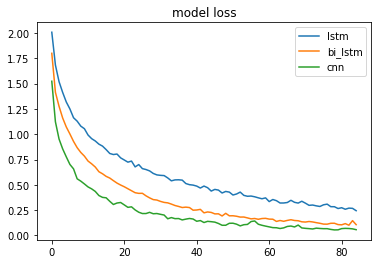

In [ ]:
loss_results.plot()
pyplot.title('model loss')
pyplot.show()

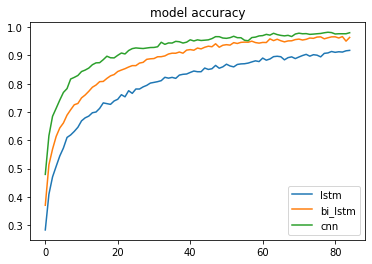

In [ ]:
acc_results.plot()
pyplot.title('model accuracy')
pyplot.show()

In [ ]:
import librosa

class_labels = ['airconditioner', 'carhorn', 'childrenplaying', 'dogbark', 
                'drilling', 'engineidling', 'gunshot', 'jackhammer',
                'siren', 'street_music']

In [ ]:
def prediction(path):
  K, sample_rate = librosa.load(path, res_type='kaiser_fast')
  test = np.mean(librosa.feature.melspectrogram(y=K, sr=sample_rate).T,axis=0)
  test = np.array(test)
  test = test.transpose()
  test = test.reshape(16, 8)
  test_cnn = test.reshape(16, 8, 1)
  q1 = class_labels[np.argmax(model1.predict(np.array([test,]))[0])]
  q2 = class_labels[np.argmax(model2.predict(np.array([test,]))[0])]
  q3 = class_labels[np.argmax(model3.predict(np.array([test_cnn,]))[0])]
  print(f'LSTM-----prediction : {q1}\nBiLSTM---prediction : {q2}\nCNN------prediction : {q3}') 

In [ ]:
path = '/content/001ca53d.wav'
sound = prediction(path)

LSTM-----prediction : street_music
BiLSTM---prediction : street_music
CNN------prediction : street_music
